# Check that Optical Density is Calculated Correctly

In [37]:
import mne
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
import os
import mne.externals.pymatreader


In [38]:
plt.rcParams["figure.figsize"] = (12,4)
# %matplotlib qt

## MATLAB
This is the exact code run to produce the MATLAB data

```matlab
addpath(genpath('nirs-toolbox'))
raw = nirs.io.loadNIRx('recording', false);
raw.probe.link([1, 26], :) 
%     source    detector    type    ShortSeperation
%     ______    ________    ____    _______________
% 
%       1          1        760          false     
%       1          1        850          false     
data = raw.data(:, [1, 26]);
save('raw_test.mat', 'data')

pipeline = nirs.modules.OpticalDensity();
pipeline = nirs.modules.BeerLambertLaw(pipeline);
BL_data = pipeline.run(raw);
BL_data.probe.link([1, 31], :) 
%     source    detector    type     ShortSeperation
%     ______    ________    _____    _______________
% 
%       1          1        'hbo'         false     
%       1          1        'hbr'         false     
data = BL_data.data(:, [1, 2]);
save('bl_test.mat', 'data')
```

In [51]:
matlab_data = mne.externals.pymatreader.read_mat('raw_test.mat')['data']

Loading C:\Users\mq20180437\mne_data\MNE-testing-data\NIRx\nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


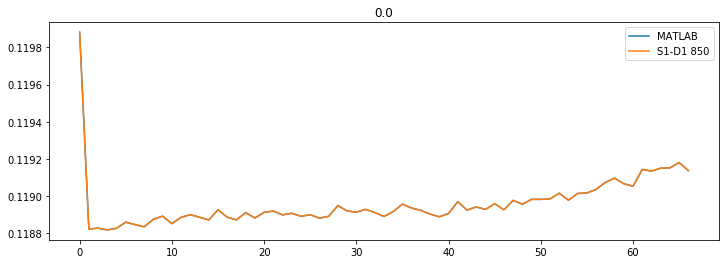

In [53]:
plt.plot(matlab_data[:,0], label='MATLAB')

raw = mne.io.read_raw_nirx('C:\\Users\\mq20180437\\mne_data\\MNE-testing-data\\NIRx\\nirx_15_2_recording', preload=True); 
plt.plot(raw.get_data()[0], label=raw.info['chs'][1]['ch_name'])
plt.title(sum(matlab_data[:,0] - raw.get_data()[0]))
plt.legend()

Loading C:\Users\mq20180437\mne_data\MNE-testing-data\NIRx\nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


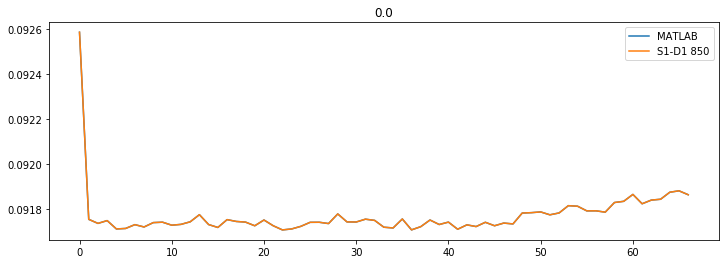

In [56]:
plt.plot(matlab_data[:,1], label='MATLAB')

mne_channel = 1

raw = mne.io.read_raw_nirx('C:\\Users\\mq20180437\\mne_data\\MNE-testing-data\\NIRx\\nirx_15_2_recording', preload=True); 
# plt.plot(raw.get_data()[1], label='MATLAB')
plt.plot(raw.get_data()[mne_channel], label=raw.info['chs'][mne_channel]['ch_name'])
plt.title(sum(matlab_data[:,1] - raw.get_data()[mne_channel]))

plt.legend()

## Python

In [57]:
raw = mne.io.read_raw_nirx('recording', preload=True); 
raw = mne.preprocessing.optical_density(raw)
raw = mne.preprocessing.beer_lambert_law(raw)

Loading recording
Reading 0 ... 11753  =      0.000 ...  1880.480 secs...


In [58]:
raw.info['chs'][0]['ch_name']
raw.info['chs'][1]['ch_name']

'S1-D1 85'

Loading C:\Users\mq20180437\mne_data\MNE-testing-data\NIRx\nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


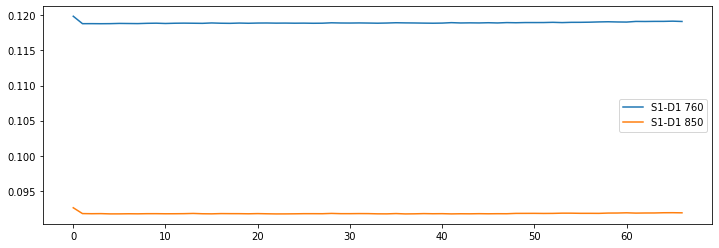

In [60]:
raw = mne.io.read_raw_nirx('C:\\Users\\mq20180437\\mne_data\\MNE-testing-data\\NIRx\\nirx_15_2_recording', preload=True); 
plt.plot(raw.get_data()[0], label=raw.info['chs'][0]['ch_name'])
plt.plot(raw.get_data()[1], label=raw.info['chs'][1]['ch_name'])
plt.legend()


Loading C:\Users\mq20180437\mne_data\MNE-testing-data\NIRx\nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


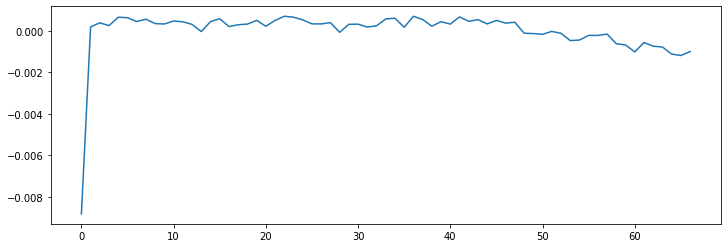

In [61]:
raw = mne.io.read_raw_nirx('C:\\Users\\mq20180437\\mne_data\\MNE-testing-data\\NIRx\\nirx_15_2_recording', preload=True); 
raw = mne.preprocessing.optical_density(raw)
plt.plot(raw.get_data()[1], label='Python')

Loading C:\Users\mq20180437\mne_data\MNE-testing-data\NIRx\nirx_15_2_recording
Reading 0 ... 66  =      0.000 ...    16.896 secs...


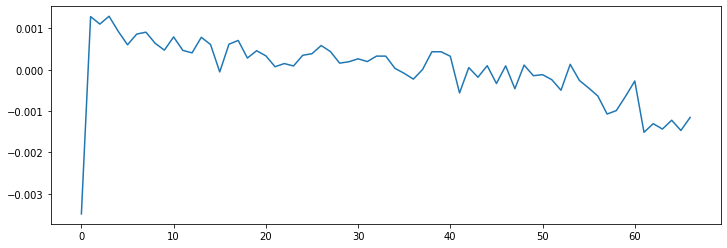

In [62]:
raw = mne.io.read_raw_nirx('C:\\Users\\mq20180437\\mne_data\\MNE-testing-data\\NIRx\\nirx_15_2_recording', preload=True); 
raw = mne.preprocessing.optical_density(raw)
raw = mne.preprocessing.beer_lambert_law(raw)
plt.plot(raw.get_data()[1], label='Python')

Text(0, 0.5, 'Optical Density')

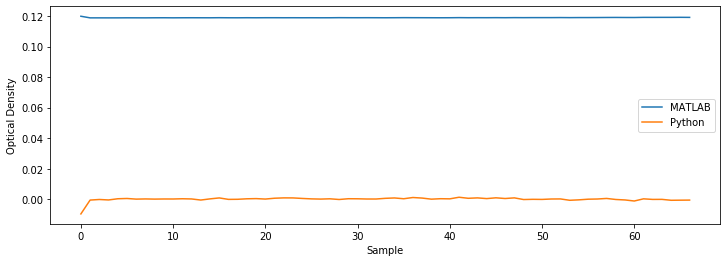

In [64]:
plt.plot(matlab_data[:,0], label='MATLAB')
plt.plot(raw.get_data()[0], label='Python')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Optical Density')

Text(0, 0.5, 'MATLAB - Python')

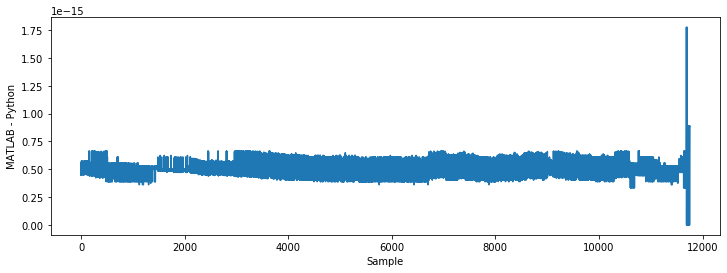

In [8]:
plt.plot(matlab_data - raw.get_data()[0], label='MATLAB')
plt.xlabel('Sample')
plt.ylabel('MATLAB - Python')

In [65]:
import mne; mne.datasets.testing.data_path(force_update=True)

Error while fetching file https://codeload.github.com/mne-tools/mne-testing-data/tar.gz/0.72. Dataset fetching aborted.


RuntimeError: URL could not be parsed properly (total size 1 != file size 1022620351)

In [68]:
np.array(0).shape

()

In [12]:
raw = mne.io.read_raw_nirx('C:\\Users\\mq20180437\\Documents\\Data\\180419-fNIRS-Tapping-Pilot\\2018-05-09_001-Tapping', preload=True); 
raw = mne.preprocessing.optical_density(raw)
raw = mne.preprocessing.beer_lambert_law(raw)

Loading C:\Users\mq20180437\Documents\Data\180419-fNIRS-Tapping-Pilot\2018-05-09_001-Tapping


RuntimeError: Only NIRStar version 15.2 is supported